In [1]:
import _fixpath
from pathlib import Path
import constants

MEDIA_ROOT = Path("/media/ko/MAUI63/2025-08-maui-winter-survey/")
ODIR = constants.TMP_DIR / "2025-08-maui-winter-survey-false-positives.fullres"

In [2]:
import json
from tqdm import tqdm

# Get all the inferences:
inference_files = []
for daydir in MEDIA_ROOT.iterdir():
    if not daydir.is_dir():
        continue
    for path in (daydir / "inferences").rglob("*.json"):
        splat = path.parts
        camera = path.parts[-4]
        day = path.parts[-6]
        folder = path.parts[-2]
        img_path = MEDIA_ROOT / day / "cameras" / camera / "DCIM" / folder / (path.stem + ".JPG")
        assert img_path.exists(), f"Image path does not exist: {img_path}"
        inference_files.append((path, img_path))
print(f"Found {len(inference_files)} inference files")

Found 160829 inference files


In [3]:
# Read detections
all_inferences = []
for fpath, img_path in tqdm(inference_files):
    with open(fpath) as json_file:
        data = json.load(json_file)
        all_inferences.append((fpath, img_path, data))

100%|██████████| 160829/160829 [00:02<00:00, 63445.96it/s]


In [4]:
# Filter to those only with detections:
all_inferences = [(fpath, img_path, data) for fpath, img_path, data in all_inferences if len(data) > 0]
print(f"Found {len(all_inferences)} inference files with detections")

Found 15172 inference files with detections


100%|██████████| 15172/15172 [00:06<00:00, 2342.22it/s]


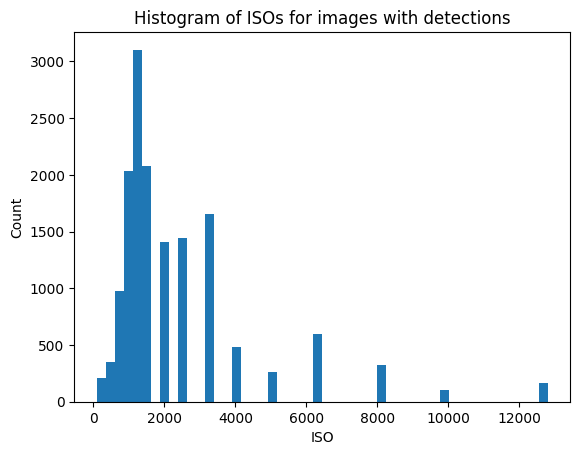

In [5]:
from img_utils import get_exif_lazy
import matplotlib.pyplot as plt

# Filter to only images with a reasonable ISO. Why? Because very high ISO images are often very noisy and blurry and sea is darker ... and whitecaps look like submerged dolphins. Don't want that.
isos = []
for fpath, img_path, data in tqdm(all_inferences):
    exif = get_exif_lazy(img_path)
    iso = int(exif["photographic_sensitivity"])
    isos.append(iso)

# Plot histogram of ISOs:
plt.hist(isos, bins=50)
plt.xlabel("ISO")
plt.ylabel("Count")
plt.title("Histogram of ISOs for images with detections")
plt.show()


In [6]:
# OK, only include those with ISO <= 1600
all_inferences = [(fpath, img_path, data) for (fpath, img_path, data), iso in zip(all_inferences, isos) if iso <= 1600]
print(f"Found {len(all_inferences)} inference files with detections and ISO <= 1600")

Found 8744 inference files with detections and ISO <= 1600


In [7]:
# Ignore those on particular dates (more chop in water etc.):
ignore_days = {"2025-08-16"}
all_inferences = [
    (fpath, img_path, data) for (fpath, img_path, data) in all_inferences if fpath.parts[-6] not in ignore_days
]
print(
    f"Found {len(all_inferences)} inference files with detections and ISO <= 1600 and not on ignored days ({ignore_days})"
)

Found 4162 inference files with detections and ISO <= 1600 and not on ignored days ({'2025-08-16'})


In [8]:
assert False

AssertionError: 

In [9]:
# Order highest to lowest by score and get top

# Note that it'd be tempting to crop around the detection - let's not. Why? Because a) it'll be in the center or same location always, and b)
# it means we can't take random crops around it later in the data prep stage. The downside is that we then risk including other false
# detections in the image, but maybe ones we wanted to exclude. (E.g. maybe the one we wanted was a patch of kelp, but there was also a
# false detection in the image that really really looked like a maui - leaving that there un-annotated could end up providing training
# data saying "this other thing is NOT a maui" which is not what we want.) So, what we'll do is we'll mask them all out in black.

import shutil
import time
import importlib
import visualizer

importlib.reload(visualizer)

from visualizer import ThreadedVisualizer
from PIL import Image, ImageDraw
from common import Annotation, Detection
from img_utils import remove_exif_orientation_if_needed

N = 1000
out_inferences = sorted(all_inferences, key=lambda x: max([i["score"] for i in x[2]]), reverse=True)[:N]

n_vis = 4
visualizers = [ThreadedVisualizer(title_prefix="False Positives") for i in range(n_vis)]

# Make review images:
oreview_dir = ODIR / "review"
oreview_dir.mkdir(parents=True, exist_ok=True)

# Go through each image, and export the image and detections to a new directory:
oimg_dir = ODIR / "images"
oannotations_dir = ODIR / "annotations"
oimg_dir.mkdir(parents=True, exist_ok=True)
oannotations_dir.mkdir(parents=True, exist_ok=True)
ODIR.mkdir(parents=True, exist_ok=True)

for idx, (a_path, img_path, detections) in tqdm(list(enumerate(out_inferences))):
    oname = str(Path(f"{idx:05d}___{str(img_path.relative_to(MEDIA_ROOT)).replace('/', '__')}").stem)
    oimg_path = oimg_dir / (oname + img_path.suffix)
    assert not oimg_path.exists()
    # Remove exif orientation if needed:
    remove_exif_orientation_if_needed(img_path, oimg_path, validate=True)
    # Load it now we've fixed orientation:
    img = Image.open(oimg_path)
    # Take crop around highest scoring detection:
    assert len(detections) > 0
    annotations = [Detection(**d) for d in detections]
    sorted_anns = sorted(annotations, key=lambda x: x.score, reverse=True)
    target = sorted_anns[0]
    maskers = sorted_anns[1:]
    # First mask:
    draw = ImageDraw.Draw(img)
    for b in maskers:
        # Only mask if it's not overlapping with target:
        if b.iou(target) < 0.1:
            draw.rectangle([b.x0, b.y0, b.x1, b.y1], fill="black")
    del draw

    # Done. Save (over top of first one with fixed orientation):
    img.save(oimg_path)

    # Write detections for this image:
    with open(oannotations_dir / (oname + ".json"), "w") as f:
        json.dump([target.to_dict()], f, indent=2)

    # Visualize:
    vis_idx = idx % n_vis
    vis = visualizers[vis_idx]
    vis.visualize(
        image_as_pil=img,
        img_path=str(oimg_path),
        out_path=oreview_dir / f"{oname}.jpg",
        detections=[target],
        annotations=None,
    )

while any([not vis.empty() for vis in visualizers]):
    time.sleep(1)
    print("Num visualizers still processing:", sum([vis.size() for vis in visualizers]))

100%|██████████| 1000/1000 [29:56<00:00,  1.80s/it]


Num visualizers still processing: 0


In [ ]:
# OK, go and delete images from oreview_dir that you don't want. Focus on keeping those that are obviously false e.g. seaweed or land or sun glint.
# Oh, and delete mauis! If it looks like it could be a submerged dolphin (even if it's a blurred white cap) - keep it ... we don't want to discourage the
# model from detecting those.
assert False, "Read the above!"

AssertionError: Read the above!

In [ ]:
import random

TRAIN_PPN = 0.9

# Now make a dataset from selected ones, inc. train test split

# Get labels
stems_to_keep = [fpath.stem for fpath in oreview_dir.iterdir()]

n_train = int(len(stems_to_keep) * TRAIN_PPN)
train = set(random.sample(stems_to_keep, n_train))
test = set(stems_to_keep) - train
assert len(train) + len(test) == len(stems_to_keep)
assert not train.intersection(test)

In [ ]:
import json
from pathlib import Path
import shutil
from PIL import Image


def make_coco(split, dolphin_name, img_root, label_root, stems, odir: Path):
    imgdir = odir / split
    if imgdir.exists():
        shutil.rmtree(imgdir)
    imgdir.mkdir(parents=True)
    all_images = []
    all_annotations = []
    for stem in sorted(list(stems)):
        img_path = img_root / f"{stem}.JPG"
        assert img_path.exists(), f"Image path does not exist: {img_path}"
        label_path = label_root / f"{stem}.json"
        assert label_path.exists(), f"Label path does not exist: {label_path}"
        shutil.copy(img_path, imgdir)
        # coco
        img = Image.open(img_path)
        width, height = img.size
        # annotations first
        annotations = []
        with open(label_path) as f:
            for label in json.load(f):
                x0 = int(label["x0"])
                y0 = int(label["y0"])
                x1 = int(label["x1"])
                y1 = int(label["y1"])
                w = x1 - x0
                h = y1 - y0
                annotations.append(
                    dict(
                        id=len(all_annotations),
                        image_id=len(all_images),
                        bbox=[x0, y0, w, h],
                        area=w * h,
                        category_id=0,
                    )
                )

        # Add both if we succeeded
        all_annotations.extend(annotations)
        all_images.append(dict(file_name=img_path.name, height=height, width=width, id=len(all_images)))

    categories = [dict(id=0, name=dolphin_name)]
    with open(odir / f"{split}.json", "w") as f:
        json.dump(dict(images=all_images, annotations=all_annotations, categories=categories), f, indent=2)


make_coco("train", "false-positive", oimg_dir, oannotations_dir, train, ODIR / "final")
make_coco("test", "false-positive", oimg_dir, oannotations_dir, test, ODIR / "final")

In [ ]:
# Save the meta:
with open(ODIR / "final" / "meta.json", "w") as f:
    json.dump({"gsd": 2.6}, f, indent=2)